# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn    import metrics
from lightgbm   import LGBMRegressor

from BorutaShap import BorutaShap

from sklearn.datasets          import load_diabetes
from sklearn.inspection        import permutation_importance
from sklearn.preprocessing     import QuantileTransformer
from sklearn.model_selection   import train_test_split, cross_validate
from sklearn.feature_selection import SelectFromModel

/home/junior/.pyenv/versions/datascience_toolkit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

pd.options.display.max_columns = None
pd.options.display.max_rows = 2000

In [3]:
def get_dimensions(df):

    print("Number of Rows: {}".format(df.shape[0]))
    print("NUmber of Cols: {}".format(df.shape[1]))

# Loading Datasets

In [4]:
X, y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)
df = pd.concat([X, y], axis=1)

X = df.drop(columns='target')
y = df.loc[:, ['target']]

# Machine Learning

## LightGBM CV

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
def get_regression_metrics(y, col_target='target', col_pred='pred', decimals=0):

    """
    Function to calculate the regression metrics: R2, RMSE, MAE, MAPE, MedAE

    Parameters
    ----------
    y : DataFrame
        Data frame with target and prediction.

    col_target : str
        The name of the columns with the target.

    col_pred : str
        The name of the columns with the prediction.

    decimals : int
        Number of decimal places to round.
    
    Returns
    -------
    dict_results : Dict
        Dictionary with metric results.
    """

    r2 = metrics.r2_score(y[col_target], y[col_pred])

    rmse = metrics.root_mean_squared_error(y[col_target], y[col_pred])

    mae = metrics.mean_absolute_error(y[col_target], y[col_pred])

    mape = metrics.mean_absolute_percentage_error(y[col_target], y[col_pred])

    medae = metrics.median_absolute_error(y[col_target], y[col_pred])

    dict_results = {
        "R2": np.round(r2, decimals), "RMSE": np.round(rmse, decimals), 
        "MAE": np.round(mae, decimals), "MAPE": np.round(mape, decimals), "MedAE": np.round(medae, decimals)}

    return dict_results

In [7]:
def select_from_model(estimator, X_train, y_train, target='target', threshold=None, max_features=None):

    sfm = SelectFromModel(estimator, threshold=threshold, max_features=max_features)
    sfm.fit(X_train, y_train[target])

    list_selected_features = X_train.loc[:, sfm.get_support()].columns.tolist()

    return list_selected_features

In [8]:
def fit_lgbm_regressor_cv(X_train, y_train, X_test, y_test, target, cv=3, params=None, random_state=42):

    cat_columns = X_train.select_dtypes(include='object')

    if any(cat_columns):

        print('---------------> Feature Engineering')
        
        X_train[cat_columns] = X_train[cat_columns].astype("category")
        X_test[cat_columns] = X_test[cat_columns].astype("category")

    print('---------------> Modeling')

    init_params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'random_state': random_state, "bagging_freq": 1, 'n_jobs': -1}
    
    if params:
        
        init_params.update(params)

    model = LGBMRegressor(**init_params)
    
    list_reg_scores = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_percentage_error']

    cv_results = cross_validate(estimator=model, X=X_train, y=y_train['target'], cv=cv, scoring=list_reg_scores)

    r2_mean = np.round(cv_results['test_r2'].mean(), 2)
    mae_mean = np.round(cv_results['test_neg_mean_absolute_error'].mean() * -1, 2)
    rmse_mean = np.round(cv_results['test_neg_root_mean_squared_error'].mean() * -1, 2)
    medae_mean = np.round(cv_results['test_neg_median_absolute_error'].mean() * -1, 2)
    mape_mean = np.round(cv_results['test_neg_mean_absolute_percentage_error'].mean() * -1, 2)

    model.fit(X_train, y_train[target])
    y_test['pred'] = model.predict(X_test)

    dict_results = get_regression_metrics(y_test, target, decimals=2)
    
    r2, mae, rmse, mape, medae = dict_results['R2'], dict_results['MAE'], dict_results['RMSE'], dict_results['MAPE'], dict_results['MedAE']

    print('---------------> Metrics')

    print(f"Cross Validation  R2: {r2_mean}, MAE: {mae_mean}, RMSE: {rmse_mean}, MAPE: {mape_mean}, MedAE: {medae_mean}")
    print(f"Test  Validation  R2: {r2}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}, MedAE: {medae}")

    return model

In [9]:
def boruta_shap_regression(
        X_train, y_train, model=None, target='target', n_trials=100, sample=False, train_or_test='test', normalize=True, verbose=False):
    
    boruta_shap = BorutaShap(model, importance_measure='shap', classification=False)
    boruta_shap.fit(
        X=X_train, y=y_train[target], n_trials=n_trials, sample=sample, 
        train_or_test=train_or_test, normalize=normalize, verbose=verbose)

    list_selected_features = boruta_shap.Subset().columns.tolist()
    
    return list_selected_features

In [10]:
def tune_params_lgbm_regression_cv(
    X_train, y_train, selected_features, n_trials=100, target='target', scoring='r2', direction='maximize', random_state=42):
    
    def objective(trial):
    
        param = {
            "objective": "regression",
            "metric": scoring,
            "verbosity": -1,
            "bagging_freq": 1,
            "n_jobs": -1,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
        }
        
        cv_results = cross_validate(
            estimator=LGBMRegressor(**param), scoring=scoring, cv=3,
            X=X_train[selected_features], y=y_train[target])
    
        score_mean = cv_results['test_score'].mean()
    
        return score_mean
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)

    best_params = {'objective': 'regression', 'verbosity': -1, 'random_state': random_state, 'metric': scoring, 'n_jobs': -1}
    best_params.update(study.best_params)
    
    return best_params

In [11]:
def get_tree_feature_importance(model, X_train):
    
    df_imp = pd.DataFrame(model.feature_importances_, X_train.columns).reset_index()
    df_imp.columns = ["Variable", "Importance"]
    df_imp = df_imp.sort_values("Importance", ascending=False)
    
    sns.barplot(x="Importance", y="Variable", color="#006e9cff", data=df_imp[:20])
    
    plt.title(f"Importance of Variables")
    plt.show()

    return df_imp

In [12]:
def get_tree_summary_plot(model, X_train):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)

In [13]:
def get_permutation_importance(model, X, y, scoring, random_state, n_repeats=5):

    dict_results = permutation_importance(
        estimator=model, X=X, y=y, scoring=scoring, random_state=random_state, n_repeats=n_repeats, n_jobs=-1)

    sorted_importances_idx = dict_results.importances_mean.argsort()
    
    df_results = pd.DataFrame(dict_results.importances[sorted_importances_idx].T, columns=X.columns[sorted_importances_idx])
    
    ax = df_results.plot.box(vert=False, whis=10)
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    
    plt.show()

    return df_results

In [14]:
def automl_lgbm_regressor_cv(
    X_train, y_train, X_test, y_test, selection_method='sfm', target='target', cv=3, n_trials=100, scoring='r2', direction='maximize'):

    dict_results = {}
    
    print('--------> Standard Model')

    _ = fit_lgbm_regressor_cv(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target=target, cv=cv)

    print('\n--------> Feature Selection')

    if selection_method == 'sfm':

        print('---------------> Select From Model')
        
        list_selected_features = select_from_model(
            estimator=LGBMRegressor(verbosity=-1, random_state=42, n_jobs=-1), X_train=X_train, y_train=y_train, target=target)

        dict_results['selected_features'] = list_selected_features
    
    elif selection_method == 'boruta':

        print('---------------> Boruta Shap')

        list_selected_features = boruta_shap_regression(
            X_train=X_train, y_train=y_train, model=LGBMRegressor(verbosity=-1, random_state=42, n_jobs=-1), 
            n_trials=100, sample=False, train_or_test='test', normalize=True, verbose=False)

        dict_results['selected_features'] = list_selected_features
    
    _ = fit_lgbm_regressor_cv(
        X_train=X_train[list_selected_features], y_train=y_train, 
        X_test=X_test[list_selected_features], y_test=y_test, target=target, cv=cv)
    
    print('\n--------> Hyperparameter Tuning')
    
    params = tune_params_lgbm_regression_cv(
        X_train, y_train, list_selected_features, n_trials=n_trials, target=target, scoring=scoring, direction=direction)

    dict_results['best_params'] = params
    
    model = fit_lgbm_regressor_cv(
        X_train=X_train[list_selected_features], y_train=y_train, X_test=X_test[list_selected_features], 
        y_test=y_test, target='target', cv=cv, params=params)

    dict_results['model'] = model
    
    print('\n--------> Feature Importance')
    
    df_imp = get_tree_feature_importance(model, X_train[list_selected_features])

    display(df_imp)

    dict_results['feature_importance'] = df_imp

    print('\n--------> Permutation Importance')

    df_perm = get_permutation_importance(model, X[list_selected_features], y[target], scoring=scoring, random_state=42, n_repeats=5)

    dict_results['permutation_importance'] = df_perm
    
    print('\n--------> Shap Values')
    
    get_tree_summary_plot(model, X_train[list_selected_features])

    return dict_results

--------> Standard Model
---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.38, MAE: 47.74, RMSE: 59.92, MAPE: 0.43, MedAE: 41.96
Test  Validation  R2: 0.51, MAE: 43.37, RMSE: 54.51, MAPE: 0.36, MedAE: 39.1

--------> Feature Selection
---------------> Select From Model
---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.35, MAE: 49.15, RMSE: 61.63, MAPE: 0.43, MedAE: 41.84
Test  Validation  R2: 0.41, MAE: 47.22, RMSE: 60.28, MAPE: 0.39, MedAE: 45.58

--------> Hyperparameter Tuning
---------------> Modeling
---------------> Metrics
Cross Validation  R2: 0.44, MAE: 47.11, RMSE: 57.13, MAPE: 0.42, MedAE: 41.5
Test  Validation  R2: 0.59, MAE: 39.52, RMSE: 49.83, MAPE: 0.37, MedAE: 35.55

--------> Feature Importance


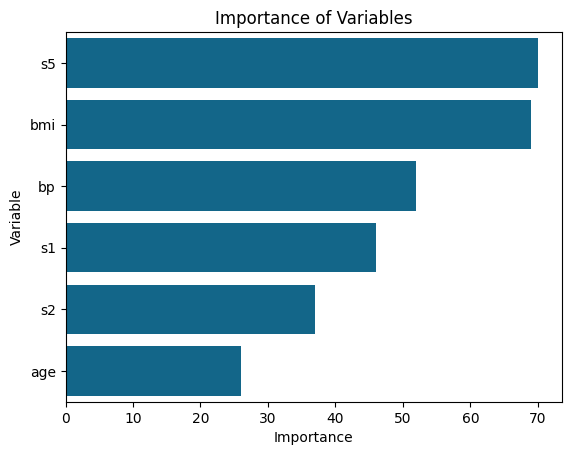

,Variable,Importance
5,s5,70
1,bmi,69
2,bp,52
3,s1,46
4,s2,37
0,age,26



--------> Permutation Importance


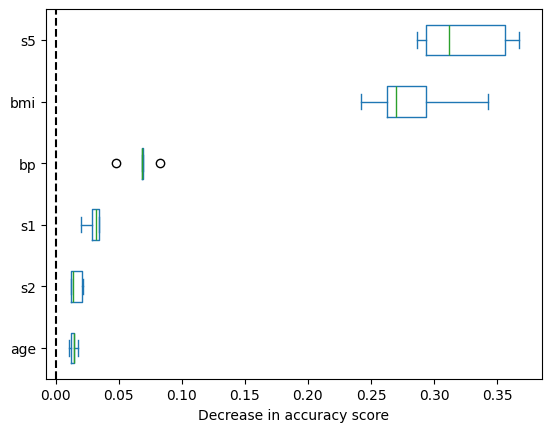


--------> Shap Values


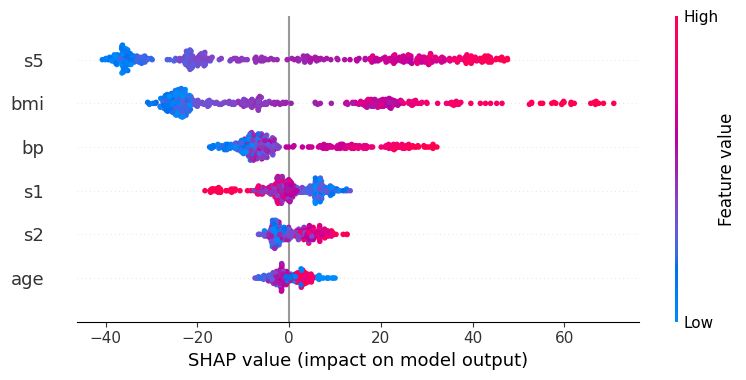

CPU times: user 4min 20s, sys: 3min, total: 7min 20s
Wall time: 1min 30s


In [26]:
%%time
dict_results = automl_lgbm_regressor_cv(
    X_train, y_train, X_test, y_test, selection_method='sfm', target='target', cv=3, n_trials=500, scoring='r2', direction='maximize')

## Simples

In [ ]:
def fit_lgbm_regressor(X_train, y_train, X_valid, y_valid, X_test, y_test, target, params=None, random_state=42):

    cat_columns = X_train.select_dtypes(include='object')

    if any(cat_columns):

        print('---------------> Feature Engineering')
        
        X_train[cat_columns] = X_train[cat_columns].astype("category")
        X_test[cat_columns] = X_test[cat_columns].astype("category")

    print('---------------> Modeling')

    init_params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'random_state': random_state, "bagging_freq": 1, 'n_jobs': -1}
    
    if params:
        
        params.update(**init_params)
        model = LGBMRegressor(**params)
    
    else:

        model = LGBMRegressor(**init_params)
    
    model.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])])

    y_train['pred'] = model.predict(X_train)
    y_valid['pred'] = model.predict(X_valid)
    y_test['pred'] = model.predict(X_test)

    train_resul = get_regression_metrics(y_train, target, decimals=2)
    valid_resul = get_regression_metrics(y_valid, target, decimals=2)
    test_resul = get_regression_metrics(y_test, target, decimals=2)

    print('---------------> Metrics')

    print(f"Train Results  R2: {train_resul['r2']}, MAE: {train_resul['mae']}, RMSE: {train_resul['rmse']}, MAPE: {train_resul['mape']}, MedAE: {train_resul['medae']}")
    print(f"Valid Results  R2: {valid_resul['r2']}, MAE: {valid_resul['mae']}, RMSE: {valid_resul['rmse']}, MAPE: {valid_resul['mape']}, MedAE: {valid_resul['medae']}")
    print(f"Test Results  R2: {test_resul['r2']}, MAE: {test_resul['mae']}, RMSE: {test_resul['rmse']}, MAPE: {test_resul['mape']}, MedAE: {test_resul['medae']}")

    return model